# Project Market Risk 

## Question A : Value At Risk

In [1]:
import warnings

# To ignore warnings
warnings.filterwarnings("ignore")

# To display all warnings again (if needed later)
# warnings.filterwarnings("default")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# Load the data 
file_path = 'Natixis_MG.xlsx'
xls = pd.ExcelFile(file_path)

# Load the content of the first sheet
data = pd.read_excel(xls)
data

,Date,Price
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453
...,...,...
1018,2018-12-21,4.045
1019,2018-12-24,4.010
1020,2018-12-27,3.938
1021,2018-12-28,4.088


In [4]:
# Convert the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter the data between January 2015 and December 2016
data_filtered = data[(data['Date'] >= '2015-01-01') & (data['Date'] <= '2016-12-31')]
data_filtered

,Date,Price
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453
...,...,...
508,2016-12-23,5.376
509,2016-12-27,5.380
510,2016-12-28,5.379
511,2016-12-29,5.328


In [5]:
# Calculate daily returns: (P_t - P_{t-1}) / P_{t-1}
data_filtered['Return'] = data_filtered['Price'].pct_change()

# Remove the first row since it contains NaN for the return
data_filtered.dropna(inplace=True)

# Display the results: Price, Return, and VaR
print("Filtered Data with Returns:")
data_filtered

Filtered Data with Returns:


,Date,Price,Return
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836
5,2015-01-09,5.340,-0.020723
...,...,...,...
508,2016-12-23,5.376,-0.008118
509,2016-12-27,5.380,0.000744
510,2016-12-28,5.379,-0.000186
511,2016-12-29,5.328,-0.009481


In [6]:
# Set a confidence level for VaR (e.g., 95% for 1-day horizon)
confidence_level = 0.95

# Calculate the VaR using the percentile of the returns distribution
VaR = np.percentile(data_filtered['Return'], (1 - confidence_level) * 100)
print(f"\nHistorical VaR at {confidence_level * 100}% confidence level: {VaR}")


Historical VaR at 95.0% confidence level: -0.03777913198405711


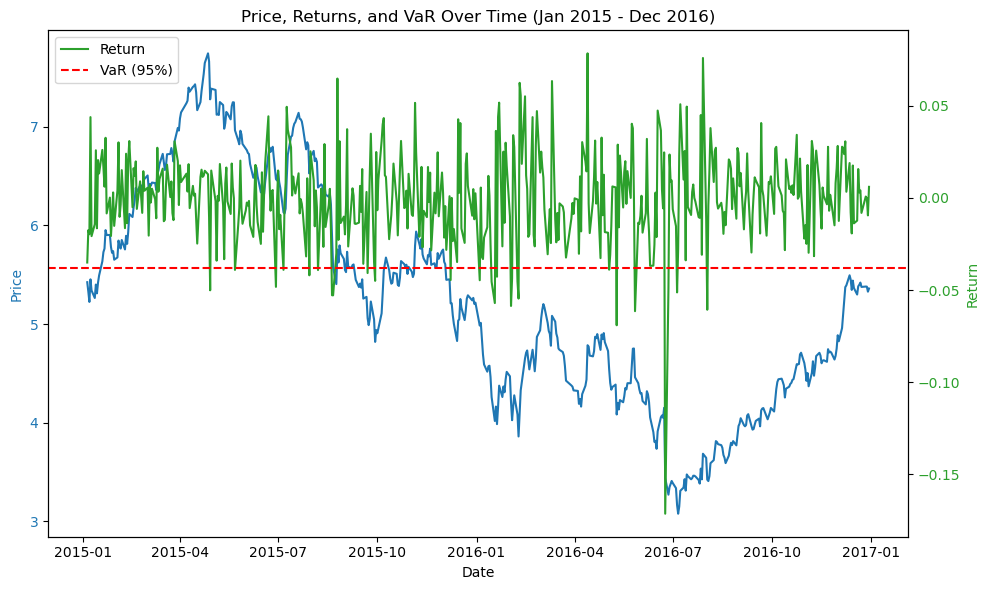

In [7]:
# Plot the price and returns over time
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Price
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='tab:blue')
ax1.plot(data_filtered['Date'], data_filtered['Price'], color='tab:blue', label='Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary axis to plot Returns
ax2 = ax1.twinx()
ax2.set_ylabel('Return', color='tab:green')
ax2.plot(data_filtered['Date'], data_filtered['Return'], color='tab:green', label='Return')
# Add VaR line
ax2.axhline(y=VaR, color='red', linestyle='--', label=f'VaR ({confidence_level*100:.0f}%)')  
ax2.tick_params(axis='y', labelcolor='tab:green')

# Add a legend for VaR
ax2.legend(loc='upper left')

# Title and plot
plt.title('Price, Returns, and VaR Over Time (Jan 2015 - Dec 2016)')
fig.tight_layout()
plt.show()

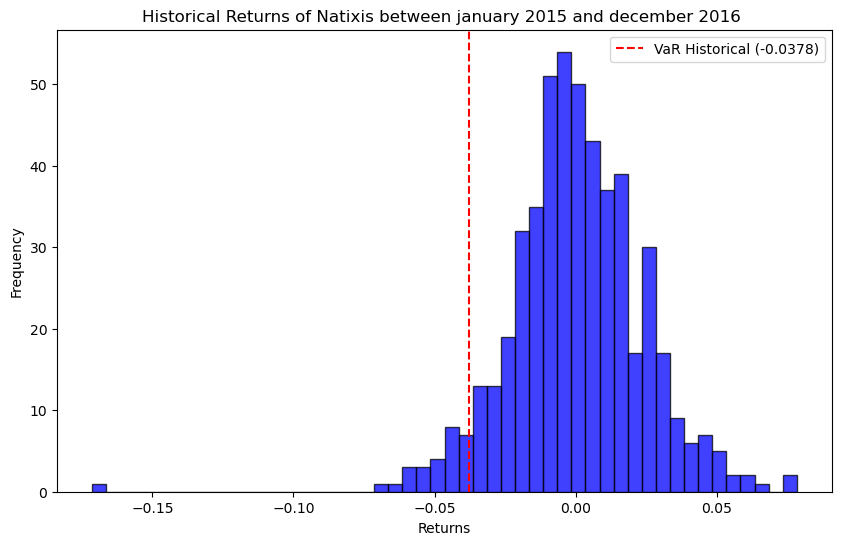

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(data_filtered['Return'], bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=VaR, color="red", linestyle="--", label=f"VaR Historical ({VaR:.4f})")
plt.title('Historical Returns of Natixis between january 2015 and december 2016 ')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [9]:
# Logistic kernel function
def logistic_kernel(u):
    return np.exp(-u) / (1 + np.exp(-u))**2

# Kernel density estimation using the logistic kernel
def kernel_density_estimate_logistic(x, data, h):
    n = len(data)
    u = (x - data) / h
    kde = np.sum(logistic_kernel(u)) / (n * h)
    return kde

# Function to calculate the empirical CDF
def integrate_cdf(kde_values, x_range):
    dx = x_range[1] - x_range[0]  
    cdf = np.cumsum(kde_values) * dx
    return cdf

In [10]:
# Bandwidth (Silverman's Rule of Thumb)
n = len(data_filtered['Return'])
# Silverman's rule of thumb
h = 1.06 * np.std(data_filtered['Return']) * (n ** (-1/5))

# Arbitrary bandwidth for comparison
h_small = 0.001

# Density estimation over a range of values
x_range = np.linspace(min(data_filtered['Return']), max(data_filtered['Return']), num=1000)
kde_values_logistic = [kernel_density_estimate_logistic(x, data_filtered['Return'], h) for x in x_range]

# Empirical CDF calculation
cdf_values = integrate_cdf(kde_values_logistic, x_range)

# VaR calculation
probability_level = 0.95
non_parametric_var_logistic = None

for i, cdf in enumerate(cdf_values):
    if cdf >= (1 - probability_level):
        non_parametric_var_logistic = x_range[i]
        break

# Find the value of VaR corresponding to the desired confidence level
non_parametric_var_logistic_message = (
    f"Non-Parametric VaR (Logistic Kernel) at {probability_level * 100}% confidence level: {non_parametric_var_logistic:.4f}"
)
print(non_parametric_var_logistic_message)

Non-Parametric VaR (Logistic Kernel) at 95.0% confidence level: -0.0431


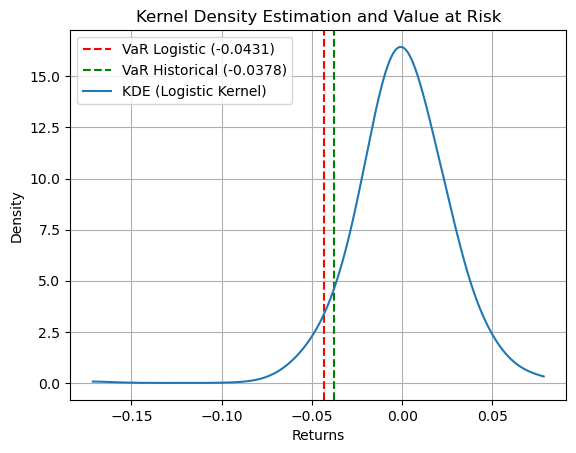

In [11]:
import matplotlib.pyplot as plt

plt.axvline(x=non_parametric_var_logistic, color="red", linestyle="--", label=f"VaR Logistic ({non_parametric_var_logistic:.4f})")
plt.axvline(x=VaR, color="green", linestyle="--", label=f"VaR Historical ({VaR:.4f})")
plt.plot(x_range, kde_values_logistic, label="KDE (Logistic Kernel)")

plt.title("Kernel Density Estimation and Value at Risk")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Filter the data between January 2017 and December 2018
data_filtered_period = data[(data['Date'] >= '2017-01-01') & (data['Date'] <= '2018-12-31')]
data_filtered_period

,Date,Price
513,2017-01-02,5.400
514,2017-01-03,5.620
515,2017-01-04,5.641
516,2017-01-05,5.595
517,2017-01-06,5.563
...,...,...
1018,2018-12-21,4.045
1019,2018-12-24,4.010
1020,2018-12-27,3.938
1021,2018-12-28,4.088


In [13]:
# Calculer les returns si nécessaire
data_filtered_period['Return'] = data_filtered_period['Price'].pct_change()
# Définir la VaR donnée
VaR_threshold = non_parametric_var_logistic

# Calculer la proportion des returns inférieurs ou égaux à la VaR
returns = data_filtered_period['Return']
below_var = returns[returns <= VaR_threshold]
proportion_below_var = len(below_var) / len(returns)

# Afficher le résultat
print(f"Proportion of returns ≤ VaR_threshold ({VaR_threshold}): {proportion_below_var * 100:.2f}%")

Proportion of returns ≤ VaR_threshold (-0.043071874142037225): 1.37%


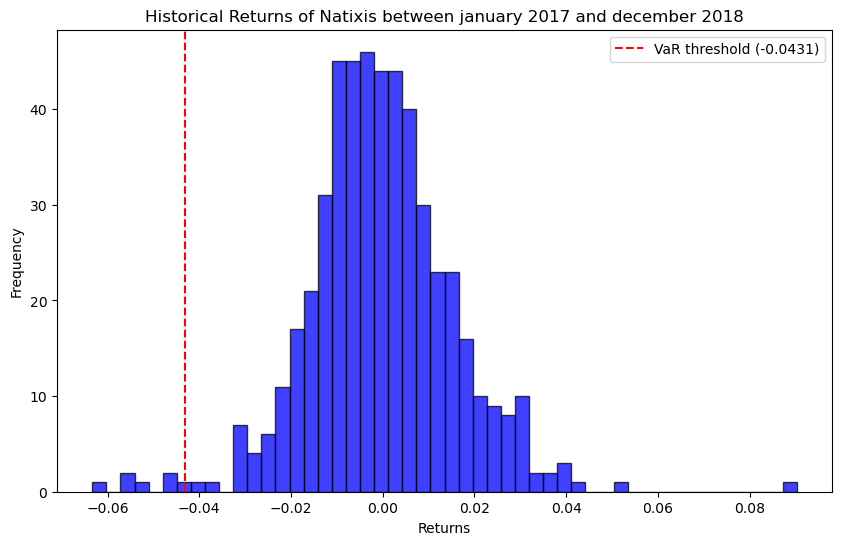

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(data_filtered_period['Return'], bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=VaR_threshold, color="red", linestyle="--", label=f"VaR threshold ({VaR_threshold:.4f})")
plt.title('Historical Returns of Natixis between january 2017 and december 2018')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Question B : Monte Carlo VaR

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [16]:
# Filter the data between January 2015 and December 2016
data_filtered_carlo = data[(data['Date'] >= '2015-01-01') & (data['Date'] <= '2018-12-31')]
data_filtered_carlo

,Date,Price
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453
...,...,...
1018,2018-12-21,4.045
1019,2018-12-24,4.010
1020,2018-12-27,3.938
1021,2018-12-28,4.088


In [17]:
# Calculate simple returns
data_filtered_carlo['Return'] = data_filtered_carlo['Price'].pct_change()

# Calculate logarithmic returns
data_filtered_carlo['Log_Return'] = np.log(data_filtered_carlo['Price'] / data_filtered_carlo['Price'].shift(1))
data_filtered_carlo.dropna(inplace=True)

# Initialise the smoothing for the first date
data_filtered_carlo.loc[data_filtered_carlo['Date'] == '2015-01-05', 'Lissage_Log_Return'] = data_filtered_carlo.loc[data_filtered_carlo['Date'] == '2015-01-05', 'Log_Return']

In [18]:
# Testing different lambda values
lambdas = [0.85, 0.90, 0.94, 0.97]
# List to store cross-validation errors
errors_cv = []  

# Cross-validation for time series
tscv = TimeSeriesSplit(n_splits=3)

for lissage in lambdas:
    mse_fold = []
    for train_index, test_index in tscv.split(data_filtered_carlo):
        train = data_filtered_carlo.iloc[train_index]
        test = data_filtered_carlo.iloc[test_index]
        
        # Calculate smoothing on training set
        train['Lissage_Test'] = train['Log_Return'] * lissage + \
                                (1 - lissage) * train['Log_Return'].shift(1)
        
        # Apply smoothing to test set
        test['Lissage_Test'] = train['Lissage_Test'].iloc[-1] * lissage + \
                               (1 - lissage) * test['Log_Return'].shift(1)
        
        # Calculate the MSE for the current fold
        mse = mean_squared_error(test['Log_Return'].iloc[1:], test['Lissage_Test'].iloc[1:])
        mse_fold.append(mse)
    
    # Add the average MSE for this lambda
    errors_cv.append(np.mean(mse_fold))

# Find the optimal lambda
optimal_lambda_cv = lambdas[np.argmin(errors_cv)]

print(f"Lambda optimal basé sur validation croisée : {optimal_lambda_cv:.2f}")

Lambda optimal basé sur validation croisée : 0.90


In [19]:
lissage = 0.90
data_filtered_carlo['Lissage_Log_Return'] = data_filtered_carlo['Lissage_Log_Return'].fillna(data_filtered_carlo['Log_Return'] * lissage + (1 - lissage) * data_filtered_carlo['Log_Return'].shift(1))
data_filtered_carlo.dropna(inplace=True)

print(data_filtered_carlo.head())

        Date  Price    Return  Log_Return  Lissage_Log_Return
1 2015-01-05  5.424 -0.035047   -0.035676           -0.035676
2 2015-01-06  5.329 -0.017515   -0.017670           -0.019471
3 2015-01-07  5.224 -0.019704   -0.019900           -0.019677
4 2015-01-08  5.453  0.043836    0.042903            0.036622
5 2015-01-09  5.340 -0.020723   -0.020940           -0.014556


In [20]:
mu_minus_sigma_carre = data_filtered_carlo['Lissage_Log_Return'].mean()
sigma = data_filtered_carlo['Lissage_Log_Return'].std()

In [21]:
mu_minus_sigma_carre

-0.0003084366224651971

In [22]:
sigma

0.018608142679754174

In [23]:
Last_Price = pd.Series(data_filtered_carlo["Price"].iloc[-1])

In [24]:
Last_Price

0    4.119
dtype: float64

In [25]:
for i in range(1000):
    Bt = np.random.randn()
    Last_Price[i+1] = 4.119 * np.exp(mu_minus_sigma_carre + sigma * Bt)

In [26]:
Last_Price

0       4.119000
1       4.206706
2       4.155353
3       4.142320
4       4.031660
          ...   
996     4.144955
997     4.146071
998     4.212002
999     4.064046
1000    4.244019
Length: 1001, dtype: float64

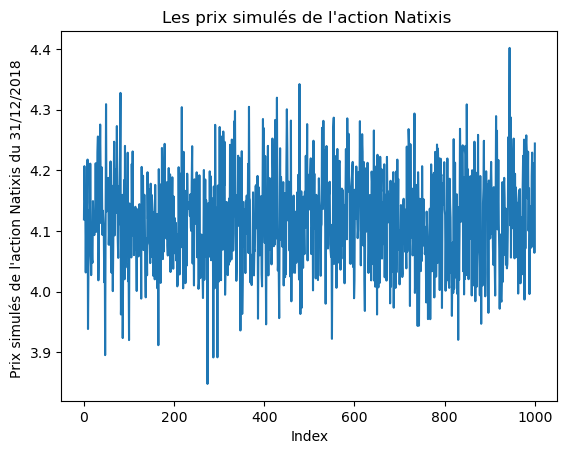

In [27]:
# Plot option prices
plt.plot(Last_Price)
plt.title("Les prix simulés de l'action Natixis ")
plt.xlabel("Index")
plt.ylabel("Prix simulés de l'action Natixis du 31/12/2018 ")
plt.show()

In [28]:
black_scholes = pd.DataFrame()
# 4.119 is the last historical price
black_scholes["d1"] = (np.log(Last_Price/4.119) + (sigma**2) / 2 * 21) / (sigma * np.sqrt(21))
black_scholes["d2"] = black_scholes["d1"] - sigma * np.sqrt(21)
black_scholes["Call Price"] = Last_Price * norm.cdf(black_scholes["d1"]) - 4.119 * norm.cdf(black_scholes["d2"])
black_scholes

,d1,d2,Call Price
0,0.042637,-0.042637,0.140082
1,0.289718,0.204445,0.189723
2,0.145681,0.060408,0.159623
3,0.108842,0.023569,0.152446
4,-0.208699,-0.293972,0.099279
...,...,...,...
996,0.116301,0.031028,0.153882
997,0.119458,0.034184,0.154492
998,0.304472,0.219199,0.192990
999,-0.114872,-0.200146,0.113392


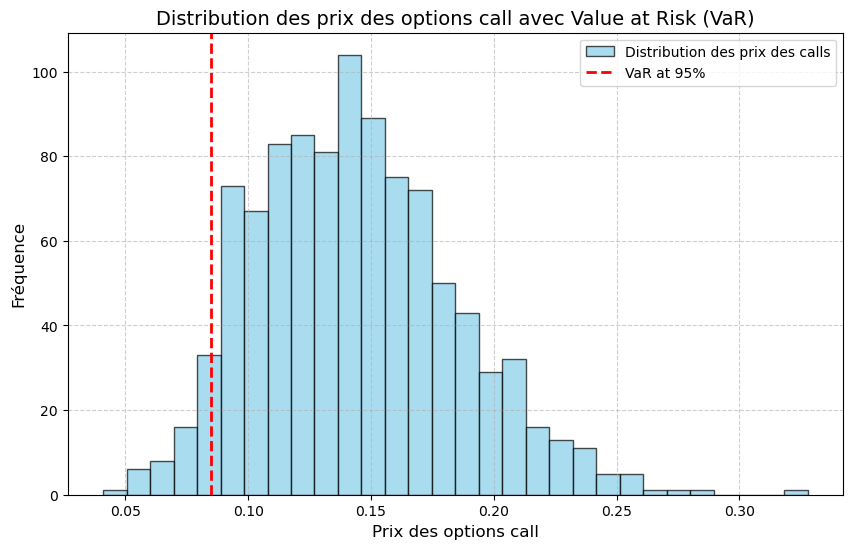

Value at Risk (VaR) at 95.0% confidence level: 0.08492202531486594


In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define the confidence level
confidence_level = 0.95  

# Extract call prices
call_prices = black_scholes["Call Price"]

# Calculate Value at Risk (VaR)
VaR_percentile = np.percentile(call_prices, (1 - confidence_level) * 100)

# Draw the histogram of call option prices
plt.figure(figsize=(10, 6))
plt.hist(call_prices, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Distribution des prix des calls')

# Add a vertical line for VaR
plt.axvline(x=VaR_percentile, color='red', linestyle='--', linewidth=2, label=f'VaR at {confidence_level*100:.0f}%')

# Add details to the graph
plt.title("Distribution des prix des options call avec Value at Risk (VaR)", fontsize=14)
plt.xlabel("Prix des options call", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Afficher le graphique
plt.show()

# Display VaR
print(f"Value at Risk (VaR) at {confidence_level * 100}% confidence level: {VaR_percentile}")


## Question C : Pickands and Extremal Index

In [30]:
data_filtered_GEV = data
data_filtered_GEV['return']=(data_filtered_GEV['Price']-data_filtered_GEV['Price'].shift(1))/data_filtered_GEV['Price'].shift(1)
data_filtered_GEV['return_positive'] = data_filtered_GEV['return'].where(data_filtered_GEV['return'] > 0, np.nan)
data_filtered_GEV['return_negative'] = data_filtered_GEV['return'].where(data_filtered_GEV['return'] < 0, np.nan)
data_filtered_GEV

,Date,Price,return,return_positive,return_negative
0,2015-01-02,5.621,NaN,NaN,NaN
1,2015-01-05,5.424,-0.035047,NaN,-0.035047
2,2015-01-06,5.329,-0.017515,NaN,-0.017515
3,2015-01-07,5.224,-0.019704,NaN,-0.019704
4,2015-01-08,5.453,0.043836,0.043836,NaN
...,...,...,...,...,...
1018,2018-12-21,4.045,-0.001481,NaN,-0.001481
1019,2018-12-24,4.010,-0.008653,NaN,-0.008653
1020,2018-12-27,3.938,-0.017955,NaN,-0.017955
1021,2018-12-28,4.088,0.038090,0.038090,NaN


In [31]:
# Create a DataFrame for positive returns
return_positive = pd.DataFrame()
return_positive= data_filtered_GEV['return_positive'].dropna()
sort_gains = np.sort(return_positive)

# Create a DataFrame for negative returns (absolute values)
return_negative = pd.DataFrame()
return_negative= data_filtered_GEV['return_negative'].dropna()
sort_losses = np.sort (abs(return_negative))



# Display the first few rows for each DataFrame
print("Positive Returns:")
print(return_positive.head())

print("\nNegative Returns (absolute values):")
print(return_negative.head())

Positive Returns:
4     0.043836
7     0.025836
9     0.020523
10    0.013284
11    0.026038
Name: return_positive, dtype: float64

Negative Returns (absolute values):
1   -0.035047
2   -0.017515
3   -0.019704
5   -0.020723
6   -0.014232
Name: return_negative, dtype: float64


In [32]:
import numpy as np

def pickands_estimator_l(extreme_values):
    
    # Calculate the Pickands estimator for the shape parameter (xi) of the GEV distribution.
    
    n = len(extreme_values)
    
    # Define k as log(n), ensure it's an integer and k > 0
    k = int(np.log(n))  
    val_1 = n - k + 1
    val_2 = n - 2 * k + 1
    val_3 = n - 4 * k + 1
    
    # Pickands estimator formula
    xi = (1 / np.log(2)) * np.log(
        (extreme_values[val_1 - 1 ] - extreme_values[val_2 - 1 ]) /
        (extreme_values[val_2 - 1  ] - extreme_values[val_3 - 1 ])
    )
    return xi

In [33]:
# Estimate Xi for both tails
xi_upper_tail_pickands_log = pickands_estimator_l(sort_gains)
xi_lower_tail_pickands__log = pickands_estimator_l(sort_losses)

In [34]:
xi_upper_tail_pickands_log

0.5772338569463286

In [35]:
xi_lower_tail_pickands__log

-0.508971577934174

In [36]:
import numpy as np

def pickands_estimator(extreme_values):
    
    # Calculate the Pickands estimator for the shape parameter (xi) of the GEV distribution.
    
    n = len(extreme_values)
    
    # Define k as sqrt(n), ensure it's an integer and k > 0
    k = int(np.sqrt(n))  
    val_1 = n - k + 1
    val_2 = n - 2 * k + 1
    val_3 = n - 4 * k + 1
    
    # Pickands estimator formula
    xi = (1 / np.log(2)) * np.log(
        (extreme_values[val_1 - 1 ] - extreme_values[val_2 - 1 ]) /
        (extreme_values[val_2 - 1  ] - extreme_values[val_3 - 1 ])
    )
    return xi

In [37]:
# Estimate Xi for both tails
xi_upper_tail_pickands_sqrt = pickands_estimator(sort_gains)
xi_lower_tail_pickands_sqrt = pickands_estimator(sort_losses)

In [38]:
xi_upper_tail_pickands_sqrt

0.7195506129332101

In [39]:
xi_lower_tail_pickands_sqrt

0.4081905706152293

In [40]:
import numpy as np

def hill_estimator(extreme_values):
   
    # Sort the extreme values in ascending order
    extreme_values = np.sort(extreme_values)
    
    # Length of the data
    n = len(extreme_values)
    
    # Define k as floor(sqrt(n))
    k = int(np.sqrt(n))
    if k <= 0:
        raise ValueError("k must be greater than 0. Ensure the sample size is sufficiently large.")
    
    # Hill estimator formula
    top_k_values = extreme_values[n - k:]  
    reference_value = extreme_values[n - k]  
    log_ratios = np.log(top_k_values / reference_value)
    xi_hill = (1 / k) * np.sum(log_ratios)
    
    return xi_hill

In [41]:
# Estimate Xi for both tails
xi_upper_tail_hill_sqrt = hill_estimator(sort_gains)
xi_lower_tail_hill_sqrt = hill_estimator(sort_losses)

In [42]:
xi_upper_tail_hill_sqrt

0.21537827843774737

In [43]:
xi_lower_tail_hill_sqrt

0.21952614389640798

In [44]:
def estimate_theta(returns, threshold_percentile=95, run_length=2):
    # Define the threshold
    threshold = np.percentile(returns, threshold_percentile)
    
    # Identify extreme indices
    extreme_indices = np.where(returns > threshold)[0]
    
    # Identify clusters
    clusters = np.split(extreme_indices, np.where(np.diff(extreme_indices) > run_length)[0] + 1)
    
    # Calculate θ
    N_e = len(extreme_indices)  
    N_c = len(clusters)       
    
    return N_c / N_e if N_e > 0 else 0

In [45]:
return_negative = abs(return_negative)

In [46]:
# Estimate θ for positive returns
theta_positive = estimate_theta(return_positive, threshold_percentile=95, run_length=5)
print(f"Index extrémal (θ) pour les gains extrêmes : {theta_positive:.4f}")

# Estimate θ for negative returns
theta_negative = estimate_theta(return_negative, threshold_percentile=95, run_length=5)
print(f"Index extrémal (θ) pour les pertes extrêmes : {theta_negative:.4f}")

Index extrémal (θ) pour les gains extrêmes : 0.6000
Index extrémal (θ) pour les pertes extrêmes : 0.5769


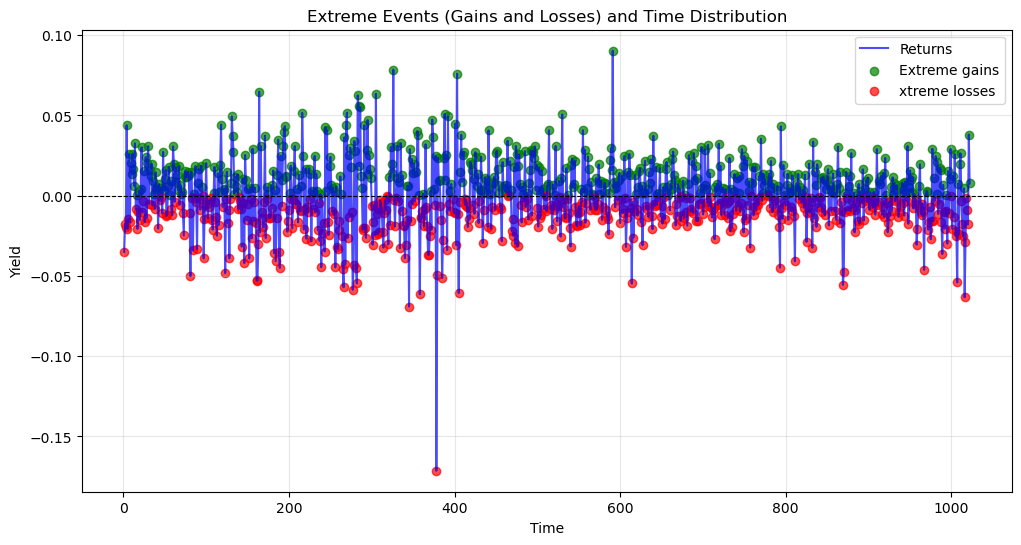

In [47]:
import matplotlib.pyplot as plt

# Plot returns with extreme events
plt.figure(figsize=(12, 6))

# Plot the yields
plt.plot(data.index, data_filtered_GEV['return'], label='Returns', color='blue', alpha=0.7)

# Highlight extreme gains
plt.scatter(return_positive.index, return_positive, color='green', label='Extreme gains', alpha=0.7)

# Highlight extreme losses (negative)
plt.scatter(return_negative.index, -return_negative, color='red', label='xtreme losses', alpha=0.7)

# Add titles and captions
plt.title("Extreme Events (Gains and Losses) and Time Distribution")
plt.xlabel("Time")
plt.ylabel("Yield")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def estimate_theta_clusters(returns, threshold_percentile=95, run_length=5):
    # Define the threshold
    threshold = np.percentile(returns, threshold_percentile)
    
    # Identify extreme indices
    extreme_indices = np.where(returns > threshold)[0]
    
    # Identify clusters
    clusters = np.split(extreme_indices, np.where(np.diff(extreme_indices) > run_length)[0] + 1)
    
    # Calculate θ
    N_e = len(extreme_indices)  
    N_c = len(clusters)        
    
    return N_c / N_e , clusters

# Estimate θ for positive returns
theta_positive, clusters_positive = estimate_theta_clusters(return_positive, threshold_percentile=95, run_length=3)
# Estimate θ for negative returns
theta_negative, clusters_negative = estimate_theta_clusters(return_negative, threshold_percentile=95, run_length=3)

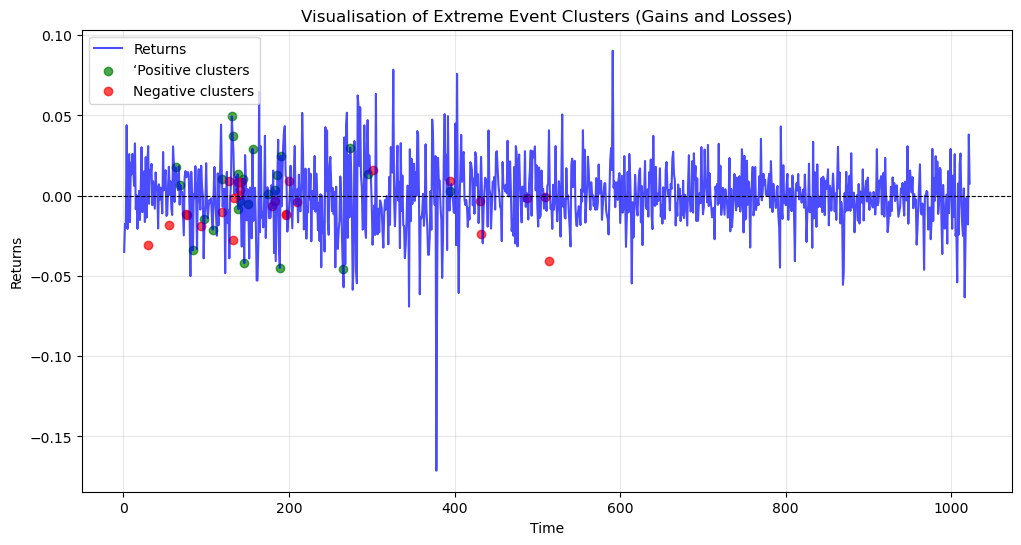

In [49]:
# Plot yields with clusters
plt.figure(figsize=(12, 6))

# Plot the returns
plt.plot(data_filtered_GEV.index, data_filtered_GEV['return'], label='Returns', color='blue', alpha=0.7)

# Display positive clusters (without repetition in the legend)
for i, cluster in enumerate(clusters_positive):
    plt.scatter(data_filtered_GEV.index[cluster], data_filtered_GEV['return'].iloc[cluster], 
                color='green', alpha=0.7, label='‘Positive clusters' if i == 0 else "")

# Display negative clusters (without repetition in the legend)
for i, cluster in enumerate(clusters_negative):
    plt.scatter(data_filtered_GEV.index[cluster], -data_filtered_GEV['return'].iloc[cluster], 
                color='red', alpha=0.7, label='Negative clusters' if i == 0 else "")

# Add titles and a unique caption
plt.title("Visualisation of Extreme Event Clusters (Gains and Losses)")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

## Question D : Almgren and Chriss

In [50]:
#Load the data 
file_path = 'Greenchriss.xlsx'
xls = pd.ExcelFile(file_path)

# Load the content of the first sheet
Grenchriss = pd.read_excel(xls)
Grenchriss

,transaction date (1=1day=24 hours),bid-ask spread,volume of the transaction (if known),Sign of the transaction,Price (before transaction)
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,NaN,1,99.984
2,0.001496,0.1015,NaN,-1,100.029
3,0.003336,0.0920,NaN,1,99.979
4,0.003952,0.1106,NaN,1,100.060
...,...,...,...,...,...
996,0.981441,0.0834,79.0,1,101.070
997,0.981875,0.1010,NaN,-1,101.120
998,0.986784,0.1007,NaN,-1,100.998
999,0.991232,0.1153,3.0,-1,100.958


In [51]:
volume = []
price = []
sign_Transaction = []
returns = []

In [52]:
volume = Grenchriss['volume of the transaction (if known)'].dropna()
volume

0        8.0
6       32.0
16       8.0
28     141.0
51     121.0
       ...  
988     14.0
989    150.0
990     17.0
996     79.0
999      3.0
Name: volume of the transaction (if known), Length: 137, dtype: float64

In [53]:
price = Grenchriss['Price (before transaction)'].dropna()
price

0       100.000
1        99.984
2       100.029
3        99.979
4       100.060
         ...   
996     101.070
997     101.120
998     100.998
999     100.958
1000    100.948
Name: Price (before transaction), Length: 1001, dtype: float64

In [54]:
sign_Transaction = Grenchriss['Sign of the transaction'].dropna()
sign_Transaction

0      -1
1       1
2      -1
3       1
4       1
       ..
996     1
997    -1
998    -1
999    -1
1000    1
Name: Sign of the transaction, Length: 1001, dtype: int64

In [55]:
returns = (Grenchriss['Price (before transaction)'] - Grenchriss['Price (before transaction)'].shift(1)) /  Grenchriss['Price (before transaction)'].shift(1)
returns.dropna(inplace=True)
returns

1      -0.000160
2       0.000450
3      -0.000500
4       0.000810
5       0.000999
          ...   
996     0.000693
997     0.000495
998    -0.001206
999    -0.000396
1000   -0.000099
Name: Price (before transaction), Length: 1000, dtype: float64

In [56]:
sigma = np.std(returns)*np.sqrt(24)*np.sqrt(252)

In [57]:
sigma

0.057397522889744174

In [58]:
import pandas as pd

# Calculation of differences with every second element skipped
price_difference = [
    price.iloc[i + 1] - price.iloc[i] 
    for i in range(0, len(price) - 1, 2)
]

# Retrieve the corresponding indices
index_difference = price.index[::2][:len(price_difference)]  

# Create a DataFrame with the original indices
price_difference_df = pd.DataFrame({
    'Price Difference': price_difference
}, index=index_difference) 

print(price_difference_df)

     Price Difference
0              -0.016
2              -0.050
4               0.100
6               0.026
8              -0.063
..                ...
990            -0.025
992            -0.031
994            -0.031
996             0.050
998            -0.040

[500 rows x 1 columns]


In [59]:
price_difference_transitoire = - price_difference_df

In [60]:
# Multiply the elements of ‘volume’ and ‘sign_Transaction’ while preserving the indices
signed_volume = {
    idx: volume[idx] * sign_Transaction[idx]
    for idx in volume.index  
    if idx in sign_Transaction.index 
}

# Convert to DataFrame for a more readable structure
signed_volume_df = pd.DataFrame(list(signed_volume.items()), columns=['Index', 'Signed Volume']).set_index('Index')

print(signed_volume_df)

       Signed Volume
Index               
0               -8.0
6               32.0
16              -8.0
28            -141.0
51            -121.0
...              ...
988            -14.0
989           -150.0
990            -17.0
996             79.0
999             -3.0

[137 rows x 1 columns]


In [61]:
# Multiply the elements of ‘volume’ and ‘sign_Transaction’ while preserving the indices
signed_volume_a = {
    idx: volume[idx] * sign_Transaction[idx]
    for idx in volume.index  
    if idx in sign_Transaction.index 
}

# Convert to DataFrame for a more readable structure
signed_volume_a = pd.DataFrame(list(signed_volume.items()), columns=['Index', 'Signed Volume']).set_index('Index')

print(signed_volume_a)

       Signed Volume
Index               
0               -8.0
6               32.0
16              -8.0
28            -141.0
51            -121.0
...              ...
988            -14.0
989           -150.0
990            -17.0
996             79.0
999             -3.0

[137 rows x 1 columns]


In [62]:
signed_volume_carre = {
    idx: volume[idx]*volume[idx] * sign_Transaction[idx]
    for idx in volume.index  # Parcourt directement les indices de 'volume'
    if idx in sign_Transaction.index  # Vérifie que l'index existe aussi dans 'sign_Transaction'
}

signed_volume_carre = pd.DataFrame(list(signed_volume_carre.items()), columns=['Index', 'Signed Volume Carre']).set_index('Index')

print(signed_volume_carre)

       Signed Volume Carre
Index                     
0                    -64.0
6                   1024.0
16                   -64.0
28                -19881.0
51                -14641.0
...                    ...
988                 -196.0
989               -22500.0
990                 -289.0
996                 6241.0
999                   -9.0

[137 rows x 1 columns]


In [63]:
# Filter impact_df to retain only the indices present in signed_volume_df
filtered_impact_df = price_difference_df[price_difference_df.index.isin(signed_volume_df.index)]
signed_volume_df = signed_volume_df[signed_volume_df.index.isin(filtered_impact_df.index)]

print(filtered_impact_df)

     Price Difference
0              -0.016
6               0.026
16             -0.019
28             -0.075
64             -0.130
..                ...
976            -0.108
982             0.059
988            -0.022
990            -0.025
996             0.050

[78 rows x 1 columns]


In [64]:
# Extract the ‘Permanent Impact’ column from filtered_impact_df
# Convert to NumPy array
Price_diff = filtered_impact_df['Price Difference'].values  
Produit_signe = signed_volume_df['Signed Volume'].values


In [65]:
def linear_regression_np(X, y):
    # Means of the data
    X_mean = np.mean(X)
    y_mean = np.mean(y)
    
    # Calculation of the slope
    slope = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean) ** 2)
    
    # Calculation of intercept
    intercept = y_mean - slope * X_mean
    
    return slope, intercept


In [66]:
slope, intercept = linear_regression_np(Produit_signe,Price_diff)

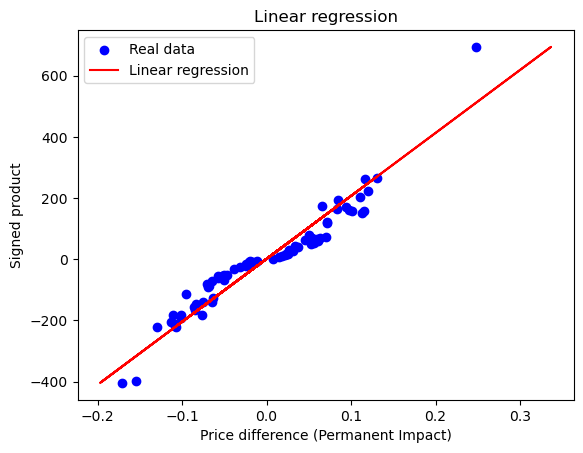

In [67]:
import matplotlib.pyplot as plt

# Predictions based on regression
y_pred = slope * Produit_signe + intercept

# Plot the actual data and the regression with inverted axes
plt.scatter(Price_diff, Produit_signe, color='blue', label='Real data')
plt.plot(y_pred, Produit_signe, color='red', label='Linear regression')
plt.xlabel("Price difference (Permanent Impact)")
plt.ylabel("Signed product")
plt.title("Linear regression")
plt.legend()
plt.show()

In [68]:
import numpy as np

# Calcul du MSE (Mean Squared Error)
mse_gamma = np.mean((Price_diff - y_pred) ** 2)

# Calcul du coefficient de détermination R^2
r2_gamma = 1 - np.sum((Price_diff - y_pred) ** 2) / np.sum((Price_diff - np.mean(Price_diff)) ** 2)

# Affichage des résultats
print(f"Estimation de gamma (pente) : {slope}")
print(f"MSE (Mean Squared Error) : {mse_gamma}")
print(f"R² (coefficient de détermination) : {r2_gamma}")


Estimation de gamma (pente) : 0.00048597289625401516
MSE (Mean Squared Error) : 0.0005047353157523114
R² (coefficient de détermination) : 0.9191664690618317


In [69]:
# Filtrer impact_df pour conserver uniquement les indices présents dans signed_volume_df
filtered_impact_tr = price_difference_transitoire[price_difference_transitoire.index.isin(signed_volume_carre.index)]
signed_volume_carre = signed_volume_carre[signed_volume_carre.index.isin(filtered_impact_tr.index)]
# Afficher le DataFrame filtré
print(filtered_impact_tr)

     Price Difference
0               0.016
6              -0.026
16              0.019
28              0.075
64              0.130
..                ...
976             0.108
982            -0.059
988             0.022
990             0.025
996            -0.050

[78 rows x 1 columns]


In [70]:
# Extraire la colonne 'Permanent Impact' de filtered_impact_df
# Convertir en tableau NumPy
Price_diff_trans = filtered_impact_tr['Price Difference'].values  
Produit_signe_carre = signed_volume_carre['Signed Volume Carre'].values

In [71]:
slope_d, intercept_d = linear_regression_np(Produit_signe_carre,Price_diff_trans)

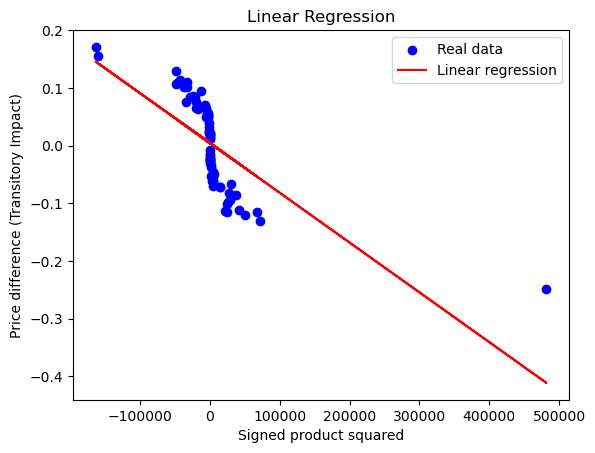

In [72]:
import matplotlib.pyplot as plt

# Prédictions basées sur la régression
y_pred_d = slope_d * Produit_signe_carre + intercept_d

# Plot real data and regression with inverted axes
plt.scatter(Produit_signe_carre, Price_diff_trans, color='blue', label='Real data')
plt.plot(Produit_signe_carre, y_pred_d, color='red', label='Linear regression')
plt.xlabel("Signed product squared")
plt.ylabel("Price difference (Transitory Impact)")
plt.title("Linear Regression")
plt.legend()
plt.show()

In [73]:
# Calculation of evaluation metrics
mse_gamma = np.mean((Price_diff_trans - y_pred_d) ** 2)
r2_gamma = 1 - np.sum((Price_diff_trans - y_pred) ** 2) / np.sum((Price_diff_trans - np.mean(Price_diff_trans)) ** 2)

print(f"Estimation de etha (pente) : {slope_d}")
print(f"MSE (Mean Squared Error) : {mse_gamma}")
print(f"R² (coefficient de détermination) : {r2_gamma}")

Estimation de etha (pente) : -8.641432875958637e-07
MSE (Mean Squared Error) : 0.0031490071046982983
R² (coefficient de détermination) : -2.764239093526162


In [74]:
import numpy as np

def linear_regression_multivariate(X, y):
    # Variable averages
    X_mean = np.mean(X, axis=0)
    y_mean = np.mean(y)

    # Covariance matrix of X
    X_cov = np.dot(X.T, X) - np.sum(X, axis=0) * X_mean

    # Inverse of the covariance matrix
    X_cov_inv = np.linalg.inv(X_cov)

    # Calculation of cross products between X and y
    X_X_mean_y_mean = np.dot(X.T, y) - np.sum(X, axis=0) * y_mean

    # Calculation of coefficients (slopes)
    coefficients = np.dot(X_cov_inv, X_X_mean_y_mean)

    # Calculation of intercept
    intercept = y_mean - np.dot(coefficients.T, X_mean)

    return coefficients, intercept

In [75]:
Xtharray = np.column_stack((Produit_signe, Produit_signe_carre))


In [76]:
coefficients, intercept_e = linear_regression_multivariate(Xtharray,Price_diff_trans)

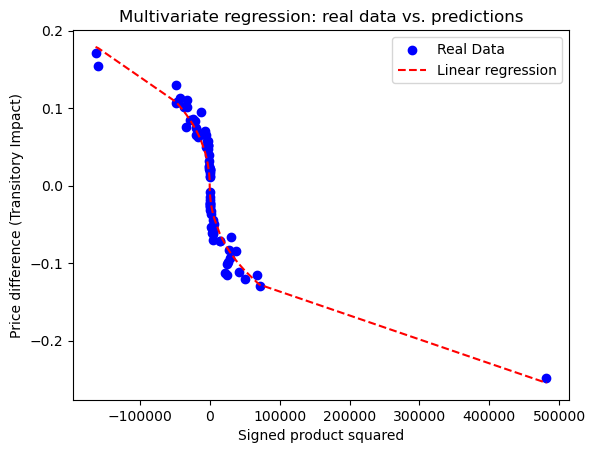

In [77]:
# Calculation of predictions
y_pred_tha = np.dot(Xtharray, coefficients) + intercept_e

# Sort the values of Product_sign_carre and y_pred_multivariate
sorted_indices = np.argsort(Produit_signe_carre)
Produit_signe_carre_sorted = Produit_signe_carre[sorted_indices]
y_pred_sorted = y_pred_tha[sorted_indices]

# Plot the actual data
plt.scatter(Produit_signe_carre, Price_diff_trans, color='blue', label='Real Data')

# Plot the linear regression curve with sorted data
plt.plot(Produit_signe_carre_sorted, y_pred_sorted, color='red', linestyle='--', label='Linear regression')

# Add labels and a title
plt.xlabel('Signed product squared')
plt.ylabel('Price difference (Transitory Impact)')
plt.title('Multivariate regression: real data vs. predictions')
plt.legend()
plt.show()



In [78]:
# Calculation of evaluation metrics
mse_tha = np.mean((Price_diff_trans - y_pred_tha) ** 2)  # Erreur quadratique moyenne (MSE)
r2_tha = 1 - sum((Price_diff_trans - y_pred_tha) ** 2) / sum((Price_diff_trans - np.mean(Price_diff_trans)) ** 2)  # R²

In [79]:
r2_tha

0.9496475740749255

In [80]:
mse_tha

0.00031440724292531187

In [81]:

tau = 1/24
etha = coefficients[1] * tau
etha

1.0911524540649711e-08

K pour λ=1.0e-05: 1.7255682401912498
K pour λ=1.0e-04: 5.456725897052854
K pour λ=1.0e-03: 17.255682401912498


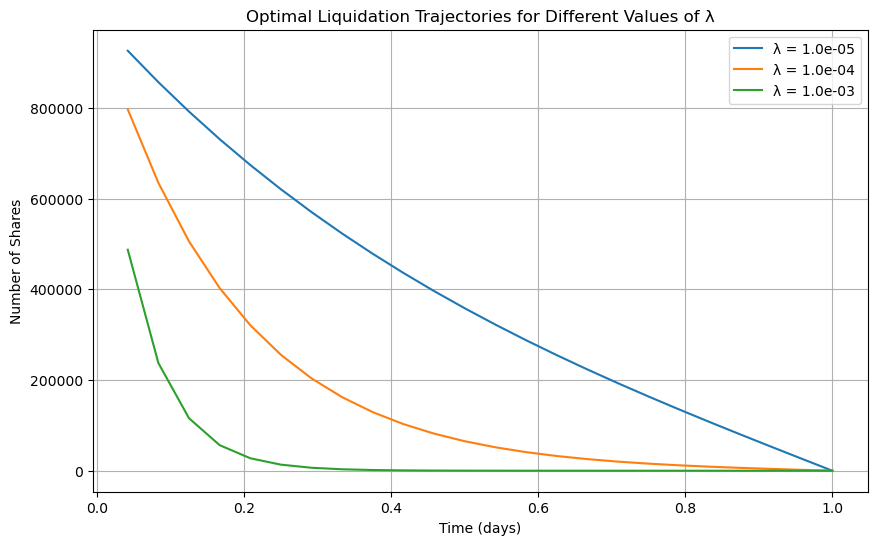

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
X = 1000000  # Initial volume to be liquidated
T = [(1 / 24) * i for i in range(1, 25)]  # Liquidation horizon in days
Lambda_values = [1e-5, 1e-4, 1e-3]  # Different lambda values
sigma = 0.057  
tha = 1.0911524540649665e-08
  

# Plot optimal liquidation paths
plt.figure(figsize=(10, 6))

for Lambda in Lambda_values:
    # Calculate K for each Lambda
    K = np.sqrt(Lambda * (sigma**2) / tha)
    print(f"K pour λ={Lambda:.1e}: {K}")  
    
    # Calculate strategic trajectories
    strat = [np.sinh(K * (1 - t)) * X / np.sinh(K) for t in T]
    
    # Plot the trajectory
    plt.plot(T, strat, label=f'λ = {Lambda:.1e}')

# Title, axes and legend
plt.title("Optimal Liquidation Trajectories for Different Values of λ")
plt.xlabel("Time (days)")
plt.ylabel("Number of Shares")
plt.legend()
plt.grid(True)
plt.show()


## Question E : Wavelets

In [83]:
# Load the data 
file_path = 'Wavelete.xlsx'
xls = pd.ExcelFile(file_path)

# Load the content of the first sheet
Wavelets = pd.read_excel(xls)
Wavelets

,Date,HIGH_GBPEUR,LOW_GBPEUR,Date.1,HIGH_SEKEUR,LOW_SEKEUR,Date.2,HIGH_CADEUR,LOW_CADEUR
0,2016-03-07 08:59:59.990,1.2932,1.2917,2016-03-07 08:59:59.990,0.10725,0.10720,2016-03-07 08:59:59.990,0.6842,0.6829
1,2016-03-07 09:15:00.000,1.2940,1.2930,2016-03-07 09:15:00.000,0.10728,0.10717,2016-03-07 09:15:00.000,0.6849,0.6841
2,2016-03-07 09:30:00.000,1.2943,1.2922,2016-03-07 09:30:00.000,0.10726,0.10719,2016-03-07 09:30:00.000,0.6844,0.6837
3,2016-03-07 09:45:00.000,1.2930,1.2913,2016-03-07 09:45:00.000,0.10728,0.10721,2016-03-07 09:45:00.000,0.6844,0.6839
4,2016-03-07 10:00:00.000,1.2931,1.2921,2016-03-07 10:00:00.000,0.10725,0.10719,2016-03-07 10:00:00.000,0.6840,0.6835
...,...,...,...,...,...,...,...,...,...
12924,2016-09-07 17:00:00.000,1.1879,1.1867,2016-09-07 17:00:00.000,0.10536,0.10531,2016-09-07 17:00:00.000,0.6897,0.6893
12925,2016-09-07 17:15:00.000,1.1883,1.1874,2016-09-07 17:15:00.000,0.10537,0.10534,2016-09-07 17:15:00.000,0.6902,0.6895
12926,2016-09-07 17:30:00.000,1.1880,1.1874,2016-09-07 17:30:00.000,0.10538,0.10536,2016-09-07 17:30:00.000,0.6902,0.6898
12927,2016-09-07 17:45:00.000,1.1874,1.1866,2016-09-07 17:45:00.000,0.10537,0.10536,2016-09-07 17:45:00.000,0.6902,0.6901


In [84]:
import pandas as pd

# Clean up column names to avoid errors caused by extra spaces
Wavelets.columns = Wavelets.columns.str.strip()

# Initialise empty DataFrames
GBPEUR = pd.DataFrame()
SEKEUR = pd.DataFrame()
CADEUR = pd.DataFrame()

# Delete rows with missing values
GBPEUR['Date'] = Wavelets['Date']
GBPEUR['HIGH_GBPEUR'] = Wavelets['HIGH_GBPEUR']
GBPEUR['LOW_GBPEUR'] = Wavelets['LOW_GBPEUR']
GBPEUR.dropna(subset=['Date', 'HIGH_GBPEUR', 'LOW_GBPEUR'], inplace=True)

SEKEUR['Date'] = Wavelets['Date']
SEKEUR['HIGH_SEKEUR'] = Wavelets['HIGH_SEKEUR']
SEKEUR['LOW_SEKEUR'] = Wavelets['LOW_SEKEUR']
SEKEUR.dropna(subset=['Date', 'HIGH_SEKEUR', 'LOW_SEKEUR'], inplace=True)

CADEUR['Date'] = Wavelets['Date']
CADEUR['HIGH_CADEUR'] = Wavelets['HIGH_CADEUR']
CADEUR['LOW_CADEUR'] = Wavelets['LOW_CADEUR']
CADEUR.dropna(subset=['Date', 'HIGH_CADEUR', 'LOW_CADEUR'], inplace=True)



In [85]:
GBPEUR

,Date,HIGH_GBPEUR,LOW_GBPEUR
0,2016-03-07 08:59:59.990,1.2932,1.2917
1,2016-03-07 09:15:00.000,1.2940,1.2930
2,2016-03-07 09:30:00.000,1.2943,1.2922
3,2016-03-07 09:45:00.000,1.2930,1.2913
4,2016-03-07 10:00:00.000,1.2931,1.2921
...,...,...,...
12924,2016-09-07 17:00:00.000,1.1879,1.1867
12925,2016-09-07 17:15:00.000,1.1883,1.1874
12926,2016-09-07 17:30:00.000,1.1880,1.1874
12927,2016-09-07 17:45:00.000,1.1874,1.1866


In [86]:
SEKEUR

,Date,HIGH_SEKEUR,LOW_SEKEUR
0,2016-03-07 08:59:59.990,0.10725,0.10720
1,2016-03-07 09:15:00.000,0.10728,0.10717
2,2016-03-07 09:30:00.000,0.10726,0.10719
3,2016-03-07 09:45:00.000,0.10728,0.10721
4,2016-03-07 10:00:00.000,0.10725,0.10719
...,...,...,...
12924,2016-09-07 17:00:00.000,0.10536,0.10531
12925,2016-09-07 17:15:00.000,0.10537,0.10534
12926,2016-09-07 17:30:00.000,0.10538,0.10536
12927,2016-09-07 17:45:00.000,0.10537,0.10536


In [87]:
CADEUR

,Date,HIGH_CADEUR,LOW_CADEUR
0,2016-03-07 08:59:59.990,0.6842,0.6829
1,2016-03-07 09:15:00.000,0.6849,0.6841
2,2016-03-07 09:30:00.000,0.6844,0.6837
3,2016-03-07 09:45:00.000,0.6844,0.6839
4,2016-03-07 10:00:00.000,0.6840,0.6835
...,...,...,...
12924,2016-09-07 17:00:00.000,0.6897,0.6893
12925,2016-09-07 17:15:00.000,0.6902,0.6895
12926,2016-09-07 17:30:00.000,0.6902,0.6898
12927,2016-09-07 17:45:00.000,0.6902,0.6901


In [88]:
GBPEUR['Mean_Price'] = (GBPEUR['HIGH_GBPEUR'] + GBPEUR['LOW_GBPEUR'])/2
SEKEUR['Mean_Price'] = (SEKEUR['HIGH_SEKEUR'] + SEKEUR['LOW_SEKEUR'])/2
CADEUR['Mean_Price'] = (CADEUR['HIGH_CADEUR'] + CADEUR['LOW_CADEUR'])/2

In [89]:
GBPEUR['GBPEUR_RETURNS'] = ((GBPEUR['Mean_Price'] - GBPEUR['Mean_Price'].shift(1)) / GBPEUR['Mean_Price'].shift(1)).dropna()
SEKEUR['SEKEUR_RETURNS'] = ((SEKEUR['Mean_Price'] - SEKEUR['Mean_Price'].shift(1)) / SEKEUR['Mean_Price'].shift(1)).dropna()
CADEUR['CADEUR_RETURNS'] = ((CADEUR['Mean_Price'] - CADEUR['Mean_Price'].shift(1)) / CADEUR['Mean_Price'].shift(1)).dropna()

GBPEUR['LOG__GBPEUR_RETURNS'] = np.log(GBPEUR['Mean_Price'] / GBPEUR['Mean_Price'].shift(1)).dropna()
SEKEUR['LOG_SEKEUR_RETURNS'] = np.log(SEKEUR['Mean_Price'] / SEKEUR['Mean_Price'].shift(1)).dropna()
CADEUR['LOG_CADEUR_RETURNS'] = np.log(CADEUR['Mean_Price'] / CADEUR['Mean_Price'].shift(1)).dropna()


GBPEUR.dropna(inplace=True)
SEKEUR.dropna(inplace=True)
CADEUR.dropna(inplace=True)

In [90]:
GBPEUR

,Date,HIGH_GBPEUR,LOW_GBPEUR,Mean_Price,GBPEUR_RETURNS,LOG__GBPEUR_RETURNS
1,2016-03-07 09:15:00,1.2940,1.2930,1.29350,0.000812,0.000812
2,2016-03-07 09:30:00,1.2943,1.2922,1.29325,-0.000193,-0.000193
3,2016-03-07 09:45:00,1.2930,1.2913,1.29215,-0.000851,-0.000851
4,2016-03-07 10:00:00,1.2931,1.2921,1.29260,0.000348,0.000348
5,2016-03-07 10:15:00,1.2926,1.2921,1.29235,-0.000193,-0.000193
...,...,...,...,...,...,...
12924,2016-09-07 17:00:00,1.1879,1.1867,1.18730,-0.000589,-0.000589
12925,2016-09-07 17:15:00,1.1883,1.1874,1.18785,0.000463,0.000463
12926,2016-09-07 17:30:00,1.1880,1.1874,1.18770,-0.000126,-0.000126
12927,2016-09-07 17:45:00,1.1874,1.1866,1.18700,-0.000589,-0.000590


In [91]:
SEKEUR

,Date,HIGH_SEKEUR,LOW_SEKEUR,Mean_Price,SEKEUR_RETURNS,LOG_SEKEUR_RETURNS
1,2016-03-07 09:15:00,0.10728,0.10717,0.107225,0.000000e+00,0.000000e+00
2,2016-03-07 09:30:00,0.10726,0.10719,0.107225,-1.294268e-16,-1.110223e-16
3,2016-03-07 09:45:00,0.10728,0.10721,0.107245,1.865237e-04,1.865063e-04
4,2016-03-07 10:00:00,0.10725,0.10719,0.107220,-2.331111e-04,-2.331383e-04
5,2016-03-07 10:15:00,0.10724,0.10718,0.107210,-9.326618e-05,-9.327053e-05
...,...,...,...,...,...,...
12924,2016-09-07 17:00:00,0.10536,0.10531,0.105335,1.424231e-04,1.424130e-04
12925,2016-09-07 17:15:00,0.10537,0.10534,0.105355,1.898704e-04,1.898524e-04
12926,2016-09-07 17:30:00,0.10538,0.10536,0.105370,1.423758e-04,1.423656e-04
12927,2016-09-07 17:45:00,0.10537,0.10536,0.105365,-4.745184e-05,-4.745296e-05


In [92]:
CADEUR

,Date,HIGH_CADEUR,LOW_CADEUR,Mean_Price,CADEUR_RETURNS,LOG_CADEUR_RETURNS
1,2016-03-07 09:15:00,0.6849,0.6841,0.68450,1.389803e-03,1.388838e-03
2,2016-03-07 09:30:00,0.6844,0.6837,0.68405,-6.574142e-04,-6.576304e-04
3,2016-03-07 09:45:00,0.6844,0.6839,0.68415,1.461881e-04,1.461775e-04
4,2016-03-07 10:00:00,0.6840,0.6835,0.68375,-5.846671e-04,-5.848381e-04
5,2016-03-07 10:15:00,0.6839,0.6836,0.68375,-1.623727e-16,-1.110223e-16
...,...,...,...,...,...,...
12924,2016-09-07 17:00:00,0.6897,0.6893,0.68950,3.627131e-04,3.626473e-04
12925,2016-09-07 17:15:00,0.6902,0.6895,0.68985,5.076142e-04,5.074854e-04
12926,2016-09-07 17:30:00,0.6902,0.6898,0.69000,2.174386e-04,2.174149e-04
12927,2016-09-07 17:45:00,0.6902,0.6901,0.69015,2.173913e-04,2.173677e-04


In [93]:
def haar_transform(data):
    data = np.array(data, dtype=float)  # Ensure the data is in a mutable array
    n = len(data)
    output = np.zeros(n)  # Initialize output array
    while n > 1:
        n = n // 2
        for i in range(n):
            # Compute averages (low frequencies)
            output[i] = (data[2 * i] + data[2 * i + 1]) / 2
            # Compute differences (high frequencies)
            output[n + i] = (data[2 * i] - data[2 * i + 1]) / 2
        # Update data for the next iteration
        data[:2 * n] = output[:2 * n]
    return output


In [94]:
gbpeur_haar = haar_transform(GBPEUR['LOG__GBPEUR_RETURNS'].values)
sekeur_haar = haar_transform(SEKEUR['LOG_SEKEUR_RETURNS'].values)
cadeur_haar = haar_transform(CADEUR['LOG_CADEUR_RETURNS'].values)

gbpeur_haar_r = haar_transform(GBPEUR['GBPEUR_RETURNS'].values)
sekeur_haar_r = haar_transform(SEKEUR['SEKEUR_RETURNS'].values)
cadeur_haar_r= haar_transform(CADEUR['CADEUR_RETURNS'].values)

GBPEUR_Average = GBPEUR['Mean_Price'].values
SEKEUR_Average = SEKEUR['Mean_Price'].values
CADEUR_Average = CADEUR['Mean_Price'] .values

In [95]:
# Multiresolution correlation with data validation
def multiresolution_correlation(haar1, haar2, level):
    length = 2 ** level
    if length > len(haar1) or length > len(haar2):
        raise ValueError(f"Level {level} exceeds the length of Haar transforms.")
    
    truncated_haar1 = haar1[:length]
    truncated_haar2 = haar2[:length]
    
    # Check whether the series are constant or empty
    if np.std(truncated_haar1) == 0 or np.std(truncated_haar2) == 0:
        return 0  
    
    return np.corrcoef(truncated_haar1, truncated_haar2)[0, 1]

In [96]:
# Correlation matrix at the given level
def correlation_matrix_at_level(level, haar_transforms):
    import pandas as pd  # For better formatting of the output

    matrix_size = len(haar_transforms)
    correlation_matrix = np.zeros((matrix_size, matrix_size))
    
    print(f"\n--- Correlation Matrix at Level {level} ---")
    
    for i in range(matrix_size):
        for j in range(i + 1, matrix_size):
            try:
                correlation = multiresolution_correlation(haar_transforms[i], haar_transforms[j], level)
            except ValueError as e:
                print(f"Error at level {level}, pair ({i}, {j}): {e}")
                correlation = 0
            correlation_matrix[i, j] = correlation_matrix[j, i] = correlation

    np.fill_diagonal(correlation_matrix, 1)  # Set diagonal to 1 (self-correlation)
    
    # Convert matrix to DataFrame for better visualization
    df_correlation = pd.DataFrame(
        correlation_matrix,
        columns=[f"Series {i+1}" for i in range(matrix_size)],
        index=[f"Series {i+1}" for i in range(matrix_size)]
    )
    
    # Print formatted correlation matrix
    print(df_correlation.to_string(float_format="{:0.2f}".format))

    return correlation_matrix


In [97]:
level = 14
# Group the Haar transformations in a list
haar_transforms = [gbpeur_haar_r, sekeur_haar_r, cadeur_haar_r ]

# Calculate the correlation matrices for each level
correlation_matrices = [correlation_matrix_at_level(lvl, haar_transforms) for lvl in range(1, level)]


--- Correlation Matrix at Level 1 ---
          Series 1  Series 2  Series 3
Series 1      1.00      1.00     -1.00
Series 2      1.00      1.00     -1.00
Series 3     -1.00     -1.00      1.00

--- Correlation Matrix at Level 2 ---
          Series 1  Series 2  Series 3
Series 1      1.00      0.37      0.29
Series 2      0.37      1.00     -0.43
Series 3      0.29     -0.43      1.00

--- Correlation Matrix at Level 3 ---
          Series 1  Series 2  Series 3
Series 1      1.00      0.33      0.17
Series 2      0.33      1.00      0.60
Series 3      0.17      0.60      1.00

--- Correlation Matrix at Level 4 ---
          Series 1  Series 2  Series 3
Series 1      1.00      0.14      0.45
Series 2      0.14      1.00      0.59
Series 3      0.45      0.59      1.00

--- Correlation Matrix at Level 5 ---
          Series 1  Series 2  Series 3
Series 1      1.00      0.41      0.22
Series 2      0.41      1.00      0.43
Series 3      0.22      0.43      1.00

--- Correlation Matrix a

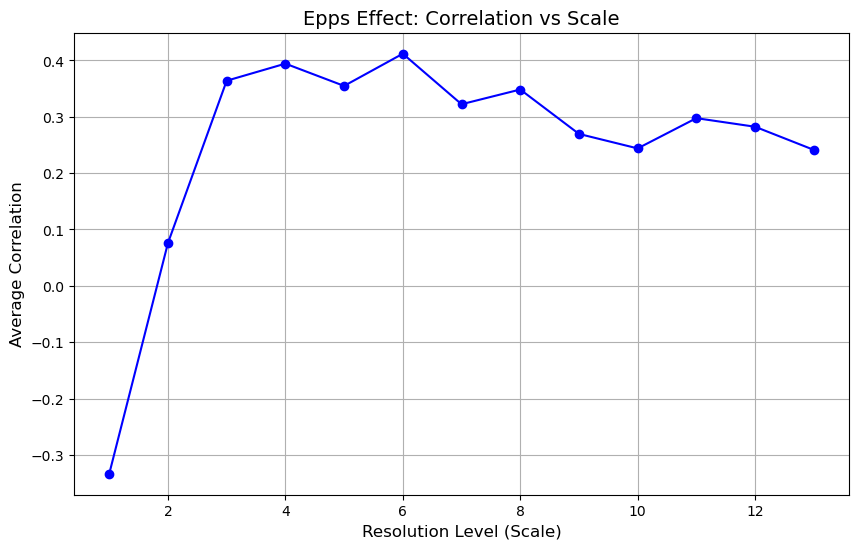

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the average correlation in a matrix
def calculate_avg_correlation(correlation_matrix):
    """
    Calcule la moyenne des corrélations dans une matrice de corrélation.
    On exclut les 1 sur la diagonale (auto-corrélations).
    """
    n = correlation_matrix.shape[0]
    upper_triangle = correlation_matrix[np.triu_indices(n, k=1)]  
    return np.mean(upper_triangle)

# Calculate the average correlations at each level
avg_correlations = [calculate_avg_correlation(matrix) for matrix in correlation_matrices]

# Plot the Epps Effect
plt.figure(figsize=(10, 6))
plt.plot(range(1, level), avg_correlations, marker='o', linestyle='-', color='b')
plt.xlabel('Resolution Level (Scale)', fontsize=12)
plt.ylabel('Average Correlation', fontsize=12)
plt.title('Epps Effect: Correlation vs Scale', fontsize=14)
plt.grid(True)
plt.show()


In [99]:
def Hurst(serie):
    T = len(serie)
    M2 = np.mean((abs(serie[1:] - serie[:-1])) ** 2)
    M2_prime = np.mean(abs((serie[2:] - serie[:-2])) ** 2)
    H_est = 0.5 * np.log2(M2_prime / M2)
    return H_est

In [100]:
hurst_gbpeur = Hurst(GBPEUR_Average)
hurst_sekeur = Hurst(SEKEUR_Average)
hurst_cadeur = Hurst(CADEUR_Average)

In [101]:
print(hurst_gbpeur)
print(hurst_sekeur)
print(hurst_cadeur)

0.6796285622373308
0.6672914562994289
0.6681148469080467


In [102]:
df_gbpeur = pd.DataFrame(GBPEUR)

# Convert the ‘Date’ column to datetime
df_gbpeur['Date'] = pd.to_datetime(df_gbpeur['Date'])

# Extract only the date (without the time)
df_gbpeur['Day'] = df_gbpeur['Date'].dt.date

# Find the last price for each day
last_prices_gbpeur = df_gbpeur.groupby('Day')['Mean_Price'].last().reset_index()

print(last_prices_gbpeur)

            Day  Mean_Price
0    2016-03-07     1.29480
1    2016-03-08     1.29115
2    2016-03-09     1.29255
3    2016-03-10     1.27785
4    2016-03-11     1.29025
..          ...         ...
154  2016-09-02     1.19165
155  2016-09-04     1.19230
156  2016-09-05     1.19380
157  2016-09-06     1.19345
158  2016-09-07     1.18695

[159 rows x 2 columns]


In [103]:
last_prices_gbpeur_average = df_gbpeur['Mean_Price'].values

In [104]:
df_sekeur = pd.DataFrame(SEKEUR)

# Convert the ‘Date’ column to datetime
df_sekeur['Date'] = pd.to_datetime(df_sekeur['Date'])

# Extract only the date 
df_sekeur['Day'] = df_sekeur['Date'].dt.date

# Find the last price for each day
last_prices_sekeur = df_sekeur.groupby('Day')['Mean_Price'].last().reset_index()

print(last_prices_sekeur)

            Day  Mean_Price
0    2016-03-07    0.107125
1    2016-03-08    0.107045
2    2016-03-09    0.107670
3    2016-03-10    0.106865
4    2016-03-11    0.107520
..          ...         ...
154  2016-09-02    0.104415
155  2016-09-04    0.104435
156  2016-09-05    0.104695
157  2016-09-06    0.104940
158  2016-09-07    0.105370

[159 rows x 2 columns]


In [105]:
last_prices_sekeur_average = df_sekeur['Mean_Price'].values

In [106]:
df_cadeur = pd.DataFrame(CADEUR)

# Convert the ‘Date’ column to datetime
df_cadeur['Date'] = pd.to_datetime(df_cadeur['Date'])

# Extract only the date 
df_cadeur['Day'] = df_cadeur['Date'].dt.date

# Find the last price for each day
last_prices_cadeur = df_cadeur.groupby('Day')['Mean_Price'].last().reset_index()

print(last_prices_cadeur)

            Day  Mean_Price
0    2016-03-07     0.68310
1    2016-03-08     0.67705
2    2016-03-09     0.68635
3    2016-03-10     0.67040
4    2016-03-11     0.67850
..          ...         ...
154  2016-09-02     0.69025
155  2016-09-04     0.69015
156  2016-09-05     0.69390
157  2016-09-06     0.69170
158  2016-09-07     0.69010

[159 rows x 2 columns]


In [107]:
last_prices_cadeur_average = df_cadeur['Mean_Price'].values

In [108]:
def calculate_daily_volatility(series):

    returns = (series[1:] - series[:-1]) / series[:-1]

    return np.std(returns)

In [109]:
def annualized_volatility(daily_vol, hurst_exponent):
    return daily_vol * (252 ** hurst_exponent)

In [110]:
gbpeur_daily_vol = calculate_daily_volatility(last_prices_gbpeur_average)
sekeur_daily_vol = calculate_daily_volatility(last_prices_sekeur_average)
cadeur_daily_vol = calculate_daily_volatility(last_prices_cadeur_average)

In [111]:
gbpeur_annual_vol = annualized_volatility(gbpeur_daily_vol, hurst_gbpeur)
sekeur_annual_vol = annualized_volatility(sekeur_daily_vol, hurst_sekeur)
cadeur_annual_vol = annualized_volatility(cadeur_daily_vol, hurst_cadeur)

In [112]:
gbpeur_daily_vol

0.0006232313739448586

In [113]:
gbpeur_annual_vol

0.02671220289724281

In [114]:
sekeur_daily_vol

0.00032713099343330195

In [115]:
sekeur_annual_vol

0.013096515357121826

In [116]:
cadeur_daily_vol

0.0005061314890089248

In [117]:
cadeur_annual_vol

0.020355168999834087